#### Loading the necessary libraries and packages

In [1]:
# Load tensorflow
import tensorflow as tf
# Below command is to avoid the known bug which prevents computation on some GPU devices
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
# Load preprocessing tools
from tensorflow.keras.utils import Sequence
from scipy.ndimage.filters import gaussian_filter
from PIL import Image
# Load model building blocks
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
# Load pre-trained model library
from tensorflow.keras import applications
# Load miscelaneous librariesm
import numpy as np
import os
import matplotlib.pylab as plt
import gc

#### Define paths

In [2]:
train_image_path = os.path.join('/home', 'renat_sergazinov', 
                                'python-git-workspace', 'PhotoForceReconML', 'image_data', 'train')
val_image_path = os.path.join('/home', 'renat_sergazinov', 
                                'python-git-workspace', 'PhotoForceReconML', 'image_data', 'val')
train_label_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'labels', 'train')
val_label_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'labels', 'val')
models_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'models')

#### Data preprocessing and augmentation

Sort the labels according to the inner (contact) angle.

In [ ]:
%run '/home/renat_sergazinov/python-git-workspace/PhotoForceReconML/data_loader.py'

In [3]:
# Load the train and validation sets

X_train, X_val = {}, {}
y_train, y_val = {}, {}

for k in range(5):
    i = k + 2
    X_path_train = os.path.join(train_image_path, str(i))
    X_path_val = os.path.join(val_image_path, str(i))
    X_train[i] = [os.path.join(X_path_train, name) for name in sorted(os.listdir(X_path_train), key = sorter)]
    X_val[i] = [os.path.join(X_path_val, name) for name in sorted(os.listdir(X_path_val), key = sorter)]
    y_train[i] = np.load(os.path.join(train_label_path, str(i), 'mags.npy'))
    y_val[i] = np.load(os.path.join(val_label_path, str(i), 'mags.npy'))

Data generators are created and defind here. Images are blurred using Gaussian blur with kernel radius = 1.The pixel values are scaled using 1/255 to be in the interval [0,1]. The images are further rescaled to 128*128 with Nearest interpolation. 

In [6]:
# Apply data generators
gaussblur = GaussBlur(1)
params = {'batch_size': 32, 
          'dim': (128, 128), 
          'n_channels': 3, 
          'rescale': 1 / 255, 
          'shuffle': True, 
          'save_dir': None,
          'preprocessing_func': gaussblur.blur
          }

training_generator = {}
validation_generator = {}

for k in range(5):
    i = k + 2
    training_generator[i] = DataGeneratorTrain(X_train[i], y_train[i], **params)
    validation_generator[i] = DataGeneratorTrain(X_val[i], y_val[i], **params)

[0.0645081 0.0645081]
[0.12076428 0.13670658 0.21766164]
[0.499427   0.31032562 0.42958317 0.57161693]
[0.57704938 0.47698032 0.37538795 0.51281312 0.47878567]
[0.49179839 0.83912281 0.94003956 0.76992417 1.02176361 0.79016967]


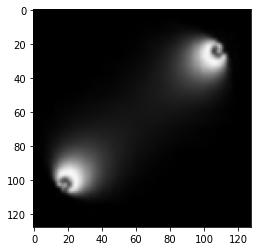

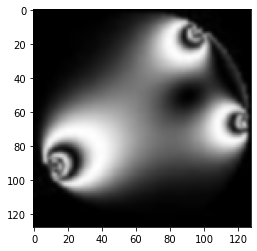

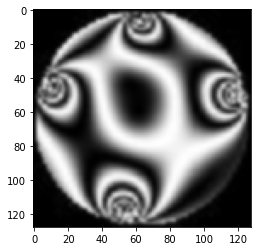

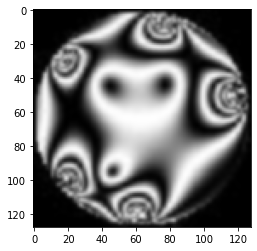

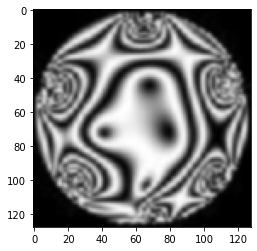

In [7]:
# Generate a sample of images for inspection

test_generator = {}
for k in range(5):
    i = k + 2
    test_generator[i] = DataGenerator(X_train[i], y_train[i], **params)
    x, y = test_generator[i].__getitem__(0)
    plt.figure()
    plt.imshow(np.asarray(x[3, ]))
    print(y[3])

#### XCEPTION Models Building

Convolutional neural networks is defined and compiled in this step.

In [8]:
base_model = {}

# Load XCEPTION model to be the base model
for k in range(5):
    i = k + 2
    base_model[i] = applications.Xception(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_shape=(128, 128, 3),
        include_top=False)
    base_model[i].trainable = False

In [9]:
# Define the model
model = {}
for k in range(5):
    i = k + 2
    inputs = Input(shape=(128, 128, 3))
    x = base_model[i](inputs, training = False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(i, activation='linear')(x)
    model[i] = Model(inputs, outputs)

#### XCEPTION Model Training

The model is trained using Adam optimizer. The loss is defined to be mean absolute error. Best model selection across training epochs is implemented with model checkpoint tracking the validation loss. Early stopping is set with patience of 30 epochs. 

In [10]:
for k in range(5):
    i = 2 + k
    model[i].compile(optimizer=tf.keras.optimizers.Adam(epsilon=0.1),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])

In [11]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = dict()
for k in range(5):
    i = k + 2
    model_path = os.path.join(models_path, 'xception_mags_'+str(i)+'.h5')
    mc[i] = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [12]:
epochs = 200
history = {}

for k in range(5):
    i = k + 2
    print('Model for ', i, ' angles')
    history[i] = model[i].fit(training_generator[i],
                            validation_data = validation_generator[i],
                            epochs = epochs,
                            steps_per_epoch = len(training_generator[i]),
                            validation_steps = len(validation_generator[i]),
                            callbacks=[es, mc[i]]
                           )

Model for  2  angles
Epoch 1/200
500/500 [==============================] - ETA: 0s - loss: 0.3128 - mean_absolute_error: 0.3128
Epoch 00001: val_loss improved from inf to 0.07084, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_2.h5
500/500 [==============================] - 48s 96ms/step - loss: 0.3128 - mean_absolute_error: 0.3128 - val_loss: 0.0708 - val_mean_absolute_error: 0.0708
Epoch 2/200
500/500 [==============================] - ETA: 0s - loss: 0.0991 - mean_absolute_error: 0.0991
Epoch 00002: val_loss improved from 0.07084 to 0.03581, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_2.h5
500/500 [==============================] - 40s 80ms/step - loss: 0.0991 - mean_absolute_error: 0.0991 - val_loss: 0.0358 - val_mean_absolute_error: 0.0358
Epoch 3/200
500/500 [==============================] - ETA: 0s - loss: 0.0566 - mean_absolute_error: 0.0566
Epoch 00003: val_loss improve

Epoch 23/200
500/500 [==============================] - ETA: 0s - loss: 0.0250 - mean_absolute_error: 0.0250
Epoch 00023: val_loss did not improve from 0.01392
500/500 [==============================] - 41s 81ms/step - loss: 0.0250 - mean_absolute_error: 0.0250 - val_loss: 0.0155 - val_mean_absolute_error: 0.0155
Epoch 24/200
500/500 [==============================] - ETA: 0s - loss: 0.0246 - mean_absolute_error: 0.0246
Epoch 00024: val_loss improved from 0.01392 to 0.01366, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_2.h5
500/500 [==============================] - 39s 79ms/step - loss: 0.0246 - mean_absolute_error: 0.0246 - val_loss: 0.0137 - val_mean_absolute_error: 0.0137
Epoch 25/200
500/500 [==============================] - ETA: 0s - loss: 0.0248 - mean_absolute_error: 0.0248
Epoch 00025: val_loss improved from 0.01366 to 0.01350, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_ma

Epoch 47/200
500/500 [==============================] - ETA: 0s - loss: 0.0221 - mean_absolute_error: 0.0221
Epoch 00047: val_loss did not improve from 0.01243
500/500 [==============================] - 39s 79ms/step - loss: 0.0221 - mean_absolute_error: 0.0221 - val_loss: 0.0153 - val_mean_absolute_error: 0.0153
Epoch 48/200
500/500 [==============================] - ETA: 0s - loss: 0.0222 - mean_absolute_error: 0.0222
Epoch 00048: val_loss did not improve from 0.01243
500/500 [==============================] - 39s 78ms/step - loss: 0.0222 - mean_absolute_error: 0.0222 - val_loss: 0.0137 - val_mean_absolute_error: 0.0137
Epoch 49/200
500/500 [==============================] - ETA: 0s - loss: 0.0226 - mean_absolute_error: 0.0226
Epoch 00049: val_loss did not improve from 0.01243
500/500 [==============================] - 39s 78ms/step - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0147 - val_mean_absolute_error: 0.0147
Epoch 50/200
500/500 [==============================] -

Epoch 72/200
500/500 [==============================] - ETA: 0s - loss: 0.0212 - mean_absolute_error: 0.0212
Epoch 00072: val_loss did not improve from 0.01144
500/500 [==============================] - 40s 80ms/step - loss: 0.0212 - mean_absolute_error: 0.0212 - val_loss: 0.0123 - val_mean_absolute_error: 0.0123
Epoch 73/200
499/500 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_error: 0.0211
Epoch 00073: val_loss did not improve from 0.01144
500/500 [==============================] - 40s 80ms/step - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0119 - val_mean_absolute_error: 0.0119
Epoch 74/200
500/500 [==============================] - ETA: 0s - loss: 0.0212 - mean_absolute_error: 0.0212
Epoch 00074: val_loss did not improve from 0.01144
500/500 [==============================] - 39s 78ms/step - loss: 0.0212 - mean_absolute_error: 0.0212 - val_loss: 0.0130 - val_mean_absolute_error: 0.0130
Epoch 75/200
500/500 [==============================] -

500/500 [==============================] - ETA: 0s - loss: 0.0199 - mean_absolute_error: 0.0199
Epoch 00122: val_loss did not improve from 0.01070
500/500 [==============================] - 40s 80ms/step - loss: 0.0199 - mean_absolute_error: 0.0199 - val_loss: 0.0110 - val_mean_absolute_error: 0.0110
Epoch 123/200
500/500 [==============================] - ETA: 0s - loss: 0.0199 - mean_absolute_error: 0.0199
Epoch 00123: val_loss did not improve from 0.01070
500/500 [==============================] - 40s 79ms/step - loss: 0.0199 - mean_absolute_error: 0.0199 - val_loss: 0.0109 - val_mean_absolute_error: 0.0109
Epoch 124/200
499/500 [============================>.] - ETA: 0s - loss: 0.0197 - mean_absolute_error: 0.0197
Epoch 00124: val_loss did not improve from 0.01070
500/500 [==============================] - 40s 79ms/step - loss: 0.0197 - mean_absolute_error: 0.0197 - val_loss: 0.0131 - val_mean_absolute_error: 0.0131
Epoch 125/200
500/500 [==============================] - ETA: 0s -

500/500 [==============================] - 40s 79ms/step - loss: 0.0191 - mean_absolute_error: 0.0191 - val_loss: 0.0105 - val_mean_absolute_error: 0.0105
Epoch 148/200
500/500 [==============================] - ETA: 0s - loss: 0.0193 - mean_absolute_error: 0.0193
Epoch 00148: val_loss did not improve from 0.01050
500/500 [==============================] - 40s 80ms/step - loss: 0.0193 - mean_absolute_error: 0.0193 - val_loss: 0.0127 - val_mean_absolute_error: 0.0127
Epoch 149/200
500/500 [==============================] - ETA: 0s - loss: 0.0191 - mean_absolute_error: 0.0191
Epoch 00149: val_loss did not improve from 0.01050
500/500 [==============================] - 40s 80ms/step - loss: 0.0191 - mean_absolute_error: 0.0191 - val_loss: 0.0111 - val_mean_absolute_error: 0.0111
Epoch 150/200
500/500 [==============================] - ETA: 0s - loss: 0.0194 - mean_absolute_error: 0.0194
Epoch 00150: val_loss did not improve from 0.01050
500/500 [==============================] - 38s 77ms/

Epoch 173/200
500/500 [==============================] - ETA: 0s - loss: 0.0190 - mean_absolute_error: 0.0190
Epoch 00173: val_loss did not improve from 0.00985
500/500 [==============================] - 40s 80ms/step - loss: 0.0190 - mean_absolute_error: 0.0190 - val_loss: 0.0105 - val_mean_absolute_error: 0.0105
Epoch 174/200
500/500 [==============================] - ETA: 0s - loss: 0.0189 - mean_absolute_error: 0.0189
Epoch 00174: val_loss did not improve from 0.00985
500/500 [==============================] - 40s 79ms/step - loss: 0.0189 - mean_absolute_error: 0.0189 - val_loss: 0.0101 - val_mean_absolute_error: 0.0101
Epoch 175/200
500/500 [==============================] - ETA: 0s - loss: 0.0189 - mean_absolute_error: 0.0189
Epoch 00175: val_loss did not improve from 0.00985
500/500 [==============================] - 40s 80ms/step - loss: 0.0189 - mean_absolute_error: 0.0189 - val_loss: 0.0128 - val_mean_absolute_error: 0.0128
Epoch 176/200
500/500 [=============================

Epoch 199/200
500/500 [==============================] - ETA: 0s - loss: 0.0185 - mean_absolute_error: 0.0185
Epoch 00199: val_loss did not improve from 0.00979
500/500 [==============================] - 40s 80ms/step - loss: 0.0185 - mean_absolute_error: 0.0185 - val_loss: 0.0102 - val_mean_absolute_error: 0.0102
Epoch 200/200
500/500 [==============================] - ETA: 0s - loss: 0.0186 - mean_absolute_error: 0.0186
Epoch 00200: val_loss did not improve from 0.00979
500/500 [==============================] - 40s 81ms/step - loss: 0.0186 - mean_absolute_error: 0.0186 - val_loss: 0.0117 - val_mean_absolute_error: 0.0117
Model for  3  angles
Epoch 1/200
500/500 [==============================] - ETA: 0s - loss: 0.3297 - mean_absolute_error: 0.3297
Epoch 00001: val_loss improved from inf to 0.10348, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_3.h5
500/500 [==============================] - 47s 95ms/step - loss: 0.3297 - mean_abso

500/500 [==============================] - 41s 81ms/step - loss: 0.0564 - mean_absolute_error: 0.0564 - val_loss: 0.0510 - val_mean_absolute_error: 0.0510
Epoch 20/200
500/500 [==============================] - ETA: 0s - loss: 0.0557 - mean_absolute_error: 0.0557
Epoch 00020: val_loss improved from 0.05099 to 0.05099, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_3.h5
500/500 [==============================] - 40s 80ms/step - loss: 0.0557 - mean_absolute_error: 0.0557 - val_loss: 0.0510 - val_mean_absolute_error: 0.0510
Epoch 21/200
500/500 [==============================] - ETA: 0s - loss: 0.0554 - mean_absolute_error: 0.0554
Epoch 00021: val_loss improved from 0.05099 to 0.05080, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_3.h5
500/500 [==============================] - 41s 82ms/step - loss: 0.0554 - mean_absolute_error: 0.0554 - val_loss: 0.0508 - val_mean_absolute_error: 0.05

Epoch 42/200
500/500 [==============================] - ETA: 0s - loss: 0.0492 - mean_absolute_error: 0.0492
Epoch 00042: val_loss did not improve from 0.04610
500/500 [==============================] - 40s 80ms/step - loss: 0.0492 - mean_absolute_error: 0.0492 - val_loss: 0.0476 - val_mean_absolute_error: 0.0476
Epoch 43/200
500/500 [==============================] - ETA: 0s - loss: 0.0494 - mean_absolute_error: 0.0494
Epoch 00043: val_loss did not improve from 0.04610
500/500 [==============================] - 39s 78ms/step - loss: 0.0494 - mean_absolute_error: 0.0494 - val_loss: 0.0465 - val_mean_absolute_error: 0.0465
Epoch 44/200
499/500 [============================>.] - ETA: 0s - loss: 0.0492 - mean_absolute_error: 0.0492
Epoch 00044: val_loss did not improve from 0.04610
500/500 [==============================] - 40s 81ms/step - loss: 0.0492 - mean_absolute_error: 0.0492 - val_loss: 0.0467 - val_mean_absolute_error: 0.0467
Epoch 45/200
500/500 [==============================] -

499/500 [============================>.] - ETA: 0s - loss: 0.0437 - mean_absolute_error: 0.0437
Epoch 00088: val_loss improved from 0.04206 to 0.04132, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_3.h5
500/500 [==============================] - 40s 79ms/step - loss: 0.0437 - mean_absolute_error: 0.0437 - val_loss: 0.0413 - val_mean_absolute_error: 0.0413
Epoch 89/200
500/500 [==============================] - ETA: 0s - loss: 0.0435 - mean_absolute_error: 0.0435
Epoch 00089: val_loss did not improve from 0.04132
500/500 [==============================] - 40s 79ms/step - loss: 0.0435 - mean_absolute_error: 0.0435 - val_loss: 0.0417 - val_mean_absolute_error: 0.0417
Epoch 90/200
500/500 [==============================] - ETA: 0s - loss: 0.0432 - mean_absolute_error: 0.0432
Epoch 00090: val_loss did not improve from 0.04132
500/500 [==============================] - 39s 78ms/step - loss: 0.0432 - mean_absolute_error: 0.0432 - val_loss: 

Epoch 113/200
500/500 [==============================] - ETA: 0s - loss: 0.0417 - mean_absolute_error: 0.0417
Epoch 00113: val_loss did not improve from 0.04062
500/500 [==============================] - 40s 80ms/step - loss: 0.0417 - mean_absolute_error: 0.0417 - val_loss: 0.0408 - val_mean_absolute_error: 0.0408
Epoch 114/200
500/500 [==============================] - ETA: 0s - loss: 0.0416 - mean_absolute_error: 0.0416
Epoch 00114: val_loss did not improve from 0.04062
500/500 [==============================] - 40s 80ms/step - loss: 0.0416 - mean_absolute_error: 0.0416 - val_loss: 0.0410 - val_mean_absolute_error: 0.0410
Epoch 115/200
500/500 [==============================] - ETA: 0s - loss: 0.0416 - mean_absolute_error: 0.0416
Epoch 00115: val_loss improved from 0.04062 to 0.04061, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_3.h5
500/500 [==============================] - 40s 80ms/step - loss: 0.0416 - mean_absolute_error: 0.0

Epoch 160/200
500/500 [==============================] - ETA: 0s - loss: 0.0397 - mean_absolute_error: 0.0397
Epoch 00160: val_loss improved from 0.03902 to 0.03898, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_3.h5
500/500 [==============================] - 40s 79ms/step - loss: 0.0397 - mean_absolute_error: 0.0397 - val_loss: 0.0390 - val_mean_absolute_error: 0.0390
Epoch 161/200
500/500 [==============================] - ETA: 0s - loss: 0.0395 - mean_absolute_error: 0.0395
Epoch 00161: val_loss did not improve from 0.03898
500/500 [==============================] - 40s 79ms/step - loss: 0.0395 - mean_absolute_error: 0.0395 - val_loss: 0.0393 - val_mean_absolute_error: 0.0393
Epoch 162/200
499/500 [============================>.] - ETA: 0s - loss: 0.0395 - mean_absolute_error: 0.0395
Epoch 00162: val_loss did not improve from 0.03898
500/500 [==============================] - 39s 79ms/step - loss: 0.0395 - mean_absolute_error: 0.0

500/500 [==============================] - 41s 82ms/step - loss: 0.0635 - mean_absolute_error: 0.0635 - val_loss: 0.0593 - val_mean_absolute_error: 0.0593
Epoch 8/200
500/500 [==============================] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.0616
Epoch 00008: val_loss improved from 0.05934 to 0.05803, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_4.h5
500/500 [==============================] - 41s 81ms/step - loss: 0.0616 - mean_absolute_error: 0.0616 - val_loss: 0.0580 - val_mean_absolute_error: 0.0580
Epoch 9/200
499/500 [============================>.] - ETA: 0s - loss: 0.0603 - mean_absolute_error: 0.0603- ETA: 1s - loss: 0.0603 - mean
Epoch 00009: val_loss improved from 0.05803 to 0.05741, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_4.h5
500/500 [==============================] - 40s 79ms/step - loss: 0.0604 - mean_absolute_error: 0.0604 - val_loss: 0.0574 - 

500/500 [==============================] - 40s 80ms/step - loss: 0.0486 - mean_absolute_error: 0.0486 - val_loss: 0.0511 - val_mean_absolute_error: 0.0511
Epoch 52/200
500/500 [==============================] - ETA: 0s - loss: 0.0484 - mean_absolute_error: 0.0484
Epoch 00052: val_loss improved from 0.05112 to 0.05069, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_4.h5
500/500 [==============================] - 40s 81ms/step - loss: 0.0484 - mean_absolute_error: 0.0484 - val_loss: 0.0507 - val_mean_absolute_error: 0.0507
Epoch 53/200
500/500 [==============================] - ETA: 0s - loss: 0.0481 - mean_absolute_error: 0.0481
Epoch 00053: val_loss improved from 0.05069 to 0.05067, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_4.h5
500/500 [==============================] - 39s 79ms/step - loss: 0.0481 - mean_absolute_error: 0.0481 - val_loss: 0.0507 - val_mean_absolute_error: 0.05

500/500 [==============================] - 40s 80ms/step - loss: 0.0461 - mean_absolute_error: 0.0461 - val_loss: 0.0498 - val_mean_absolute_error: 0.0498
Epoch 76/200
500/500 [==============================] - ETA: 0s - loss: 0.0461 - mean_absolute_error: 0.0461
Epoch 00076: val_loss did not improve from 0.04979
500/500 [==============================] - 40s 80ms/step - loss: 0.0461 - mean_absolute_error: 0.0461 - val_loss: 0.0504 - val_mean_absolute_error: 0.0504
Epoch 77/200
500/500 [==============================] - ETA: 0s - loss: 0.0461 - mean_absolute_error: 0.0461
Epoch 00077: val_loss did not improve from 0.04979
500/500 [==============================] - 40s 80ms/step - loss: 0.0461 - mean_absolute_error: 0.0461 - val_loss: 0.0503 - val_mean_absolute_error: 0.0503
Epoch 78/200
500/500 [==============================] - ETA: 0s - loss: 0.0458 - mean_absolute_error: 0.0458
Epoch 00078: val_loss did not improve from 0.04979
500/500 [==============================] - 40s 81ms/ste

Epoch 101/200
500/500 [==============================] - ETA: 0s - loss: 0.0441 - mean_absolute_error: 0.0441
Epoch 00101: val_loss improved from 0.04946 to 0.04929, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_4.h5
500/500 [==============================] - 40s 81ms/step - loss: 0.0441 - mean_absolute_error: 0.0441 - val_loss: 0.0493 - val_mean_absolute_error: 0.0493
Epoch 102/200
500/500 [==============================] - ETA: 0s - loss: 0.0442 - mean_absolute_error: 0.0442
Epoch 00102: val_loss did not improve from 0.04929
500/500 [==============================] - 39s 79ms/step - loss: 0.0442 - mean_absolute_error: 0.0442 - val_loss: 0.0494 - val_mean_absolute_error: 0.0494
Epoch 103/200
500/500 [==============================] - ETA: 0s - loss: 0.0441 - mean_absolute_error: 0.0441
Epoch 00103: val_loss did not improve from 0.04929
500/500 [==============================] - 39s 79ms/step - loss: 0.0441 - mean_absolute_error: 0.0

Epoch 125/200
500/500 [==============================] - ETA: 0s - loss: 0.0430 - mean_absolute_error: 0.0430
Epoch 00125: val_loss did not improve from 0.04884
500/500 [==============================] - 40s 80ms/step - loss: 0.0430 - mean_absolute_error: 0.0430 - val_loss: 0.0489 - val_mean_absolute_error: 0.0489
Epoch 126/200
500/500 [==============================] - ETA: 0s - loss: 0.0424 - mean_absolute_error: 0.0424
Epoch 00126: val_loss improved from 0.04884 to 0.04875, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_4.h5
500/500 [==============================] - 40s 80ms/step - loss: 0.0424 - mean_absolute_error: 0.0424 - val_loss: 0.0487 - val_mean_absolute_error: 0.0487
Epoch 127/200
500/500 [==============================] - ETA: 0s - loss: 0.0429 - mean_absolute_error: 0.0429
Epoch 00127: val_loss did not improve from 0.04875
500/500 [==============================] - 40s 81ms/step - loss: 0.0429 - mean_absolute_error: 0.0

500/500 [==============================] - 40s 79ms/step - loss: 0.0415 - mean_absolute_error: 0.0415 - val_loss: 0.0483 - val_mean_absolute_error: 0.0483
Epoch 150/200
500/500 [==============================] - ETA: 0s - loss: 0.0416 - mean_absolute_error: 0.0416
Epoch 00150: val_loss improved from 0.04832 to 0.04832, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_4.h5
500/500 [==============================] - 40s 79ms/step - loss: 0.0416 - mean_absolute_error: 0.0416 - val_loss: 0.0483 - val_mean_absolute_error: 0.0483
Epoch 151/200
500/500 [==============================] - ETA: 0s - loss: 0.0412 - mean_absolute_error: 0.0412
Epoch 00151: val_loss did not improve from 0.04832
500/500 [==============================] - 40s 80ms/step - loss: 0.0412 - mean_absolute_error: 0.0412 - val_loss: 0.0487 - val_mean_absolute_error: 0.0487
Epoch 152/200
500/500 [==============================] - ETA: 0s - loss: 0.0417 - mean_absolute_error: 0

Epoch 174/200
500/500 [==============================] - ETA: 0s - loss: 0.0406 - mean_absolute_error: 0.0406
Epoch 00174: val_loss did not improve from 0.04789
500/500 [==============================] - 40s 80ms/step - loss: 0.0406 - mean_absolute_error: 0.0406 - val_loss: 0.0482 - val_mean_absolute_error: 0.0482
Epoch 175/200
500/500 [==============================] - ETA: 0s - loss: 0.0404 - mean_absolute_error: 0.0404
Epoch 00175: val_loss did not improve from 0.04789
500/500 [==============================] - 39s 78ms/step - loss: 0.0404 - mean_absolute_error: 0.0404 - val_loss: 0.0485 - val_mean_absolute_error: 0.0485
Epoch 176/200
499/500 [============================>.] - ETA: 0s - loss: 0.0404 - mean_absolute_error: 0.0404
Epoch 00176: val_loss did not improve from 0.04789
500/500 [==============================] - 41s 81ms/step - loss: 0.0404 - mean_absolute_error: 0.0404 - val_loss: 0.0481 - val_mean_absolute_error: 0.0481
Epoch 177/200
500/500 [=============================

Epoch 19/200
500/500 [==============================] - ETA: 0s - loss: 0.0524 - mean_absolute_error: 0.0524
Epoch 00019: val_loss improved from 0.05717 to 0.05692, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_5.h5
500/500 [==============================] - 40s 80ms/step - loss: 0.0524 - mean_absolute_error: 0.0524 - val_loss: 0.0569 - val_mean_absolute_error: 0.0569
Epoch 20/200
499/500 [============================>.] - ETA: 0s - loss: 0.0521 - mean_absolute_error: 0.0521
Epoch 00020: val_loss improved from 0.05692 to 0.05662, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_5.h5
500/500 [==============================] - 39s 79ms/step - loss: 0.0521 - mean_absolute_error: 0.0521 - val_loss: 0.0566 - val_mean_absolute_error: 0.0566
Epoch 21/200
500/500 [==============================] - ETA: 0s - loss: 0.0519 - mean_absolute_error: 0.0519
Epoch 00021: val_loss did not improve from 

Epoch 42/200
500/500 [==============================] - ETA: 0s - loss: 0.0482 - mean_absolute_error: 0.0482
Epoch 00042: val_loss did not improve from 0.05446
500/500 [==============================] - 40s 80ms/step - loss: 0.0482 - mean_absolute_error: 0.0482 - val_loss: 0.0553 - val_mean_absolute_error: 0.0553
Epoch 43/200
499/500 [============================>.] - ETA: 0s - loss: 0.0482 - mean_absolute_error: 0.0482
Epoch 00043: val_loss did not improve from 0.05446
500/500 [==============================] - 40s 79ms/step - loss: 0.0482 - mean_absolute_error: 0.0482 - val_loss: 0.0549 - val_mean_absolute_error: 0.0549
Epoch 44/200
500/500 [==============================] - ETA: 0s - loss: 0.0480 - mean_absolute_error: 0.0480
Epoch 00044: val_loss did not improve from 0.05446
500/500 [==============================] - 40s 80ms/step - loss: 0.0480 - mean_absolute_error: 0.0480 - val_loss: 0.0546 - val_mean_absolute_error: 0.0546
Epoch 45/200
500/500 [==============================] -

500/500 [==============================] - 39s 79ms/step - loss: 0.0457 - mean_absolute_error: 0.0457 - val_loss: 0.0535 - val_mean_absolute_error: 0.0535
Epoch 67/200
500/500 [==============================] - ETA: 0s - loss: 0.0455 - mean_absolute_error: 0.0455
Epoch 00067: val_loss did not improve from 0.05346
500/500 [==============================] - 40s 80ms/step - loss: 0.0455 - mean_absolute_error: 0.0455 - val_loss: 0.0538 - val_mean_absolute_error: 0.0538
Epoch 68/200
500/500 [==============================] - ETA: 0s - loss: 0.0455 - mean_absolute_error: 0.0455
Epoch 00068: val_loss did not improve from 0.05346
500/500 [==============================] - 41s 81ms/step - loss: 0.0455 - mean_absolute_error: 0.0455 - val_loss: 0.0539 - val_mean_absolute_error: 0.0539
Epoch 69/200
499/500 [============================>.] - ETA: 0s - loss: 0.0456 - mean_absolute_error: 0.0456
Epoch 00069: val_loss improved from 0.05346 to 0.05334, saving model to /home/renat_sergazinov/python-git-

Epoch 90/200
500/500 [==============================] - ETA: 0s - loss: 0.0441 - mean_absolute_error: 0.0441
Epoch 00090: val_loss did not improve from 0.05273
500/500 [==============================] - 40s 81ms/step - loss: 0.0441 - mean_absolute_error: 0.0441 - val_loss: 0.0531 - val_mean_absolute_error: 0.0531
Epoch 91/200
500/500 [==============================] - ETA: 0s - loss: 0.0441 - mean_absolute_error: 0.0441
Epoch 00091: val_loss improved from 0.05273 to 0.05248, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_5.h5
500/500 [==============================] - 41s 82ms/step - loss: 0.0441 - mean_absolute_error: 0.0441 - val_loss: 0.0525 - val_mean_absolute_error: 0.0525
Epoch 92/200
500/500 [==============================] - ETA: 0s - loss: 0.0439 - mean_absolute_error: 0.0439
Epoch 00092: val_loss improved from 0.05248 to 0.05236, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_ma

Epoch 115/200
500/500 [==============================] - ETA: 0s - loss: 0.0425 - mean_absolute_error: 0.0425
Epoch 00115: val_loss did not improve from 0.05215
500/500 [==============================] - 40s 79ms/step - loss: 0.0425 - mean_absolute_error: 0.0425 - val_loss: 0.0527 - val_mean_absolute_error: 0.0527
Epoch 116/200
500/500 [==============================] - ETA: 0s - loss: 0.0424 - mean_absolute_error: 0.0424
Epoch 00116: val_loss did not improve from 0.05215
500/500 [==============================] - 40s 80ms/step - loss: 0.0424 - mean_absolute_error: 0.0424 - val_loss: 0.0527 - val_mean_absolute_error: 0.0527
Epoch 117/200
500/500 [==============================] - ETA: 0s - loss: 0.0426 - mean_absolute_error: 0.0426
Epoch 00117: val_loss did not improve from 0.05215
500/500 [==============================] - 40s 80ms/step - loss: 0.0426 - mean_absolute_error: 0.0426 - val_loss: 0.0524 - val_mean_absolute_error: 0.0524
Epoch 118/200
500/500 [=============================

Epoch 140/200
499/500 [============================>.] - ETA: 0s - loss: 0.0415 - mean_absolute_error: 0.0415
Epoch 00140: val_loss did not improve from 0.05175
500/500 [==============================] - 40s 79ms/step - loss: 0.0415 - mean_absolute_error: 0.0415 - val_loss: 0.0524 - val_mean_absolute_error: 0.0524
Epoch 141/200
500/500 [==============================] - ETA: 0s - loss: 0.0416 - mean_absolute_error: 0.0416
Epoch 00141: val_loss did not improve from 0.05175
500/500 [==============================] - 40s 80ms/step - loss: 0.0416 - mean_absolute_error: 0.0416 - val_loss: 0.0522 - val_mean_absolute_error: 0.0522
Epoch 142/200
499/500 [============================>.] - ETA: 0s - loss: 0.0414 - mean_absolute_error: 0.0414
Epoch 00142: val_loss did not improve from 0.05175
500/500 [==============================] - 40s 80ms/step - loss: 0.0413 - mean_absolute_error: 0.0413 - val_loss: 0.0523 - val_mean_absolute_error: 0.0523
Epoch 143/200
500/500 [=============================

500/500 [==============================] - ETA: 0s - loss: 0.0583 - mean_absolute_error: 0.0583
Epoch 00015: val_loss improved from 0.04809 to 0.04808, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_6.h5
500/500 [==============================] - 40s 80ms/step - loss: 0.0583 - mean_absolute_error: 0.0583 - val_loss: 0.0481 - val_mean_absolute_error: 0.0481
Epoch 16/200
499/500 [============================>.] - ETA: 0s - loss: 0.0578 - mean_absolute_error: 0.0578
Epoch 00016: val_loss improved from 0.04808 to 0.04806, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_6.h5
500/500 [==============================] - 41s 81ms/step - loss: 0.0578 - mean_absolute_error: 0.0578 - val_loss: 0.0481 - val_mean_absolute_error: 0.0481
Epoch 17/200
500/500 [==============================] - ETA: 0s - loss: 0.0576 - mean_absolute_error: 0.0576
Epoch 00017: val_loss improved from 0.04806 to 0.04787, 

Epoch 37/200
499/500 [============================>.] - ETA: 0s - loss: 0.0531 - mean_absolute_error: 0.0531
Epoch 00037: val_loss improved from 0.04629 to 0.04610, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_6.h5
500/500 [==============================] - 40s 81ms/step - loss: 0.0531 - mean_absolute_error: 0.0531 - val_loss: 0.0461 - val_mean_absolute_error: 0.0461
Epoch 38/200
500/500 [==============================] - ETA: 0s - loss: 0.0529 - mean_absolute_error: 0.0529
Epoch 00038: val_loss did not improve from 0.04610
500/500 [==============================] - 40s 80ms/step - loss: 0.0529 - mean_absolute_error: 0.0529 - val_loss: 0.0465 - val_mean_absolute_error: 0.0465
Epoch 39/200
500/500 [==============================] - ETA: 0s - loss: 0.0530 - mean_absolute_error: 0.0530
Epoch 00039: val_loss did not improve from 0.04610
500/500 [==============================] - 40s 80ms/step - loss: 0.0530 - mean_absolute_error: 0.0530

Epoch 61/200
500/500 [==============================] - ETA: 0s - loss: 0.0505 - mean_absolute_error: 0.0505
Epoch 00061: val_loss did not improve from 0.04536
500/500 [==============================] - 39s 79ms/step - loss: 0.0505 - mean_absolute_error: 0.0505 - val_loss: 0.0456 - val_mean_absolute_error: 0.0456
Epoch 62/200
500/500 [==============================] - ETA: 0s - loss: 0.0507 - mean_absolute_error: 0.0507
Epoch 00062: val_loss did not improve from 0.04536
500/500 [==============================] - 39s 78ms/step - loss: 0.0507 - mean_absolute_error: 0.0507 - val_loss: 0.0455 - val_mean_absolute_error: 0.0455
Epoch 63/200
500/500 [==============================] - ETA: 0s - loss: 0.0502 - mean_absolute_error: 0.0502
Epoch 00063: val_loss did not improve from 0.04536
500/500 [==============================] - 40s 80ms/step - loss: 0.0502 - mean_absolute_error: 0.0502 - val_loss: 0.0454 - val_mean_absolute_error: 0.0454
Epoch 64/200
500/500 [==============================] -

Epoch 86/200
500/500 [==============================] - ETA: 0s - loss: 0.0486 - mean_absolute_error: 0.0486
Epoch 00086: val_loss did not improve from 0.04500
500/500 [==============================] - 40s 80ms/step - loss: 0.0486 - mean_absolute_error: 0.0486 - val_loss: 0.0455 - val_mean_absolute_error: 0.0455
Epoch 87/200
499/500 [============================>.] - ETA: 0s - loss: 0.0486 - mean_absolute_error: 0.0486
Epoch 00087: val_loss did not improve from 0.04500
500/500 [==============================] - 40s 79ms/step - loss: 0.0486 - mean_absolute_error: 0.0486 - val_loss: 0.0453 - val_mean_absolute_error: 0.0453
Epoch 88/200
499/500 [============================>.] - ETA: 0s - loss: 0.0487 - mean_absolute_error: 0.0487
Epoch 00088: val_loss did not improve from 0.04500
500/500 [==============================] - 40s 79ms/step - loss: 0.0487 - mean_absolute_error: 0.0487 - val_loss: 0.0452 - val_mean_absolute_error: 0.0452
Epoch 89/200
500/500 [==============================] -

#### XCEPTION Model Fine-tuning

In [13]:
for k in range(5):
    i = k + 2
    base_model[i].trainable = True
    model[i].summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 22,961,706
Trainable params: 22,907,178
Non-trainable params: 54,528
____________________________________________

In [14]:
for k in range(5):
    i = 2 + k
    model[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=0.1),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])

In [15]:
epochs = 100
history_ft = {}

for k in range(5):
    i = k + 2
    print('Model for ', i, ' angles')
    history_ft[i] = model[i].fit(training_generator[i],
                            validation_data = validation_generator[i],
                            epochs = epochs,
                            steps_per_epoch = len(training_generator[i]),
                            validation_steps = len(validation_generator[i]),
                            callbacks=[es, mc[i]]
                           )

Model for  2  angles
Epoch 1/100
500/500 [==============================] - ETA: 0s - loss: 0.0181 - mean_absolute_error: 0.0181
Epoch 00001: val_loss did not improve from 0.00979
500/500 [==============================] - 63s 125ms/step - loss: 0.0181 - mean_absolute_error: 0.0181 - val_loss: 0.0102 - val_mean_absolute_error: 0.0102
Epoch 2/100
500/500 [==============================] - ETA: 0s - loss: 0.0177 - mean_absolute_error: 0.0177
Epoch 00002: val_loss did not improve from 0.00979
500/500 [==============================] - 62s 125ms/step - loss: 0.0177 - mean_absolute_error: 0.0177 - val_loss: 0.0101 - val_mean_absolute_error: 0.0101
Epoch 3/100
500/500 [==============================] - ETA: 0s - loss: 0.0179 - mean_absolute_error: 0.0179
Epoch 00003: val_loss did not improve from 0.00979
500/500 [==============================] - 62s 125ms/step - loss: 0.0179 - mean_absolute_error: 0.0179 - val_loss: 0.0099 - val_mean_absolute_error: 0.0099
Epoch 4/100
500/500 [=============

Epoch 25/100
500/500 [==============================] - ETA: 0s - loss: 0.0167 - mean_absolute_error: 0.0167
Epoch 00025: val_loss did not improve from 0.00921
500/500 [==============================] - 62s 124ms/step - loss: 0.0167 - mean_absolute_error: 0.0167 - val_loss: 0.0093 - val_mean_absolute_error: 0.0093
Epoch 26/100
500/500 [==============================] - ETA: 0s - loss: 0.0170 - mean_absolute_error: 0.0170
Epoch 00026: val_loss did not improve from 0.00921
500/500 [==============================] - 62s 124ms/step - loss: 0.0170 - mean_absolute_error: 0.0170 - val_loss: 0.0092 - val_mean_absolute_error: 0.0092
Epoch 27/100
500/500 [==============================] - ETA: 0s - loss: 0.0169 - mean_absolute_error: 0.0169
Epoch 00027: val_loss did not improve from 0.00921
500/500 [==============================] - 62s 125ms/step - loss: 0.0169 - mean_absolute_error: 0.0169 - val_loss: 0.0093 - val_mean_absolute_error: 0.0093
Epoch 28/100
500/500 [==============================

Epoch 50/100
500/500 [==============================] - ETA: 0s - loss: 0.0165 - mean_absolute_error: 0.0165
Epoch 00050: val_loss did not improve from 0.00889
500/500 [==============================] - 63s 126ms/step - loss: 0.0165 - mean_absolute_error: 0.0165 - val_loss: 0.0089 - val_mean_absolute_error: 0.0089
Epoch 51/100
500/500 [==============================] - ETA: 0s - loss: 0.0165 - mean_absolute_error: 0.0165
Epoch 00051: val_loss did not improve from 0.00889
500/500 [==============================] - 62s 124ms/step - loss: 0.0165 - mean_absolute_error: 0.0165 - val_loss: 0.0089 - val_mean_absolute_error: 0.0089
Epoch 52/100
500/500 [==============================] - ETA: 0s - loss: 0.0168 - mean_absolute_error: 0.0168
Epoch 00052: val_loss did not improve from 0.00889
500/500 [==============================] - 63s 125ms/step - loss: 0.0168 - mean_absolute_error: 0.0168 - val_loss: 0.0089 - val_mean_absolute_error: 0.0089
Epoch 53/100
500/500 [==============================

Epoch 75/100
500/500 [==============================] - ETA: 0s - loss: 0.0164 - mean_absolute_error: 0.0164
Epoch 00075: val_loss did not improve from 0.00867
500/500 [==============================] - 63s 125ms/step - loss: 0.0164 - mean_absolute_error: 0.0164 - val_loss: 0.0087 - val_mean_absolute_error: 0.0087
Epoch 76/100
500/500 [==============================] - ETA: 0s - loss: 0.0163 - mean_absolute_error: 0.0163
Epoch 00076: val_loss improved from 0.00867 to 0.00867, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_2.h5
500/500 [==============================] - 63s 126ms/step - loss: 0.0163 - mean_absolute_error: 0.0163 - val_loss: 0.0087 - val_mean_absolute_error: 0.0087
Epoch 77/100
500/500 [==============================] - ETA: 0s - loss: 0.0163 - mean_absolute_error: 0.0163
Epoch 00077: val_loss improved from 0.00867 to 0.00859, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_

Epoch 99/100
500/500 [==============================] - ETA: 0s - loss: 0.0162 - mean_absolute_error: 0.0162
Epoch 00099: val_loss improved from 0.00847 to 0.00846, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_2.h5
500/500 [==============================] - 63s 126ms/step - loss: 0.0162 - mean_absolute_error: 0.0162 - val_loss: 0.0085 - val_mean_absolute_error: 0.0085
Epoch 100/100
500/500 [==============================] - ETA: 0s - loss: 0.0162 - mean_absolute_error: 0.0162
Epoch 00100: val_loss did not improve from 0.00846
500/500 [==============================] - 63s 125ms/step - loss: 0.0162 - mean_absolute_error: 0.0162 - val_loss: 0.0085 - val_mean_absolute_error: 0.0085
Model for  3  angles
Epoch 1/100
500/500 [==============================] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375
Epoch 00001: val_loss improved from 0.03804 to 0.03794, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceRec

500/500 [==============================] - 63s 126ms/step - loss: 0.0367 - mean_absolute_error: 0.0367 - val_loss: 0.0370 - val_mean_absolute_error: 0.0370
Epoch 20/100
500/500 [==============================] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363
Epoch 00020: val_loss did not improve from 0.03696
500/500 [==============================] - 63s 125ms/step - loss: 0.0363 - mean_absolute_error: 0.0363 - val_loss: 0.0370 - val_mean_absolute_error: 0.0370
Epoch 21/100
500/500 [==============================] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364
Epoch 00021: val_loss did not improve from 0.03696
500/500 [==============================] - 63s 125ms/step - loss: 0.0364 - mean_absolute_error: 0.0364 - val_loss: 0.0370 - val_mean_absolute_error: 0.0370
Epoch 22/100
500/500 [==============================] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362
Epoch 00022: val_loss improved from 0.03696 to 0.03685, saving model to /home/renat_sergazinov/python-g

Epoch 41/100
500/500 [==============================] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357
Epoch 00041: val_loss improved from 0.03642 to 0.03636, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_3.h5
500/500 [==============================] - 63s 126ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0364 - val_mean_absolute_error: 0.0364
Epoch 42/100
500/500 [==============================] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359
Epoch 00042: val_loss did not improve from 0.03636
500/500 [==============================] - 62s 125ms/step - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0364 - val_mean_absolute_error: 0.0364
Epoch 43/100
500/500 [==============================] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354
Epoch 00043: val_loss improved from 0.03636 to 0.03629, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_

500/500 [==============================] - 63s 126ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0358 - val_mean_absolute_error: 0.0358
Epoch 64/100
500/500 [==============================] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354
Epoch 00064: val_loss did not improve from 0.03578
500/500 [==============================] - 63s 125ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0359 - val_mean_absolute_error: 0.0359
Epoch 65/100
500/500 [==============================] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352
Epoch 00065: val_loss improved from 0.03578 to 0.03576, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_3.h5
500/500 [==============================] - 63s 126ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0358 - val_mean_absolute_error: 0.0358
Epoch 66/100
500/500 [==============================] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0

500/500 [==============================] - ETA: 0s - loss: 0.0390 - mean_absolute_error: 0.0390
Epoch 00008: val_loss improved from 0.04734 to 0.04733, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_4.h5
500/500 [==============================] - 63s 126ms/step - loss: 0.0390 - mean_absolute_error: 0.0390 - val_loss: 0.0473 - val_mean_absolute_error: 0.0473
Epoch 9/100
500/500 [==============================] - ETA: 0s - loss: 0.0388 - mean_absolute_error: 0.0388
Epoch 00009: val_loss improved from 0.04733 to 0.04728, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_4.h5
500/500 [==============================] - 64s 128ms/step - loss: 0.0388 - mean_absolute_error: 0.0388 - val_loss: 0.0473 - val_mean_absolute_error: 0.0473
Epoch 10/100
500/500 [==============================] - ETA: 0s - loss: 0.0386 - mean_absolute_error: 0.0386
Epoch 00010: val_loss improved from 0.04728 to 0.04726,

Epoch 29/100
500/500 [==============================] - ETA: 0s - loss: 0.0381 - mean_absolute_error: 0.0381
Epoch 00029: val_loss improved from 0.04685 to 0.04682, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_4.h5
500/500 [==============================] - 63s 126ms/step - loss: 0.0381 - mean_absolute_error: 0.0381 - val_loss: 0.0468 - val_mean_absolute_error: 0.0468
Epoch 30/100
500/500 [==============================] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.0383
Epoch 00030: val_loss did not improve from 0.04682
500/500 [==============================] - 63s 126ms/step - loss: 0.0383 - mean_absolute_error: 0.0383 - val_loss: 0.0468 - val_mean_absolute_error: 0.0468
Epoch 31/100
500/500 [==============================] - ETA: 0s - loss: 0.0381 - mean_absolute_error: 0.0381
Epoch 00031: val_loss improved from 0.04682 to 0.04676, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_

500/500 [==============================] - 63s 126ms/step - loss: 0.0381 - mean_absolute_error: 0.0381 - val_loss: 0.0465 - val_mean_absolute_error: 0.0465
Epoch 52/100
500/500 [==============================] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.0379
Epoch 00052: val_loss improved from 0.04647 to 0.04646, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_4.h5
500/500 [==============================] - 63s 126ms/step - loss: 0.0379 - mean_absolute_error: 0.0379 - val_loss: 0.0465 - val_mean_absolute_error: 0.0465
Epoch 53/100
500/500 [==============================] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380
Epoch 00053: val_loss improved from 0.04646 to 0.04645, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_4.h5
500/500 [==============================] - 63s 126ms/step - loss: 0.0380 - mean_absolute_error: 0.0380 - val_loss: 0.0464 - val_mean_absolute_error: 0

Epoch 74/100
500/500 [==============================] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.0376
Epoch 00074: val_loss improved from 0.04621 to 0.04619, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_4.h5
500/500 [==============================] - 63s 127ms/step - loss: 0.0376 - mean_absolute_error: 0.0376 - val_loss: 0.0462 - val_mean_absolute_error: 0.0462
Epoch 75/100
500/500 [==============================] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374
Epoch 00075: val_loss did not improve from 0.04619
500/500 [==============================] - 63s 125ms/step - loss: 0.0374 - mean_absolute_error: 0.0374 - val_loss: 0.0462 - val_mean_absolute_error: 0.0462
Epoch 76/100
500/500 [==============================] - ETA: 0s - loss: 0.0377 - mean_absolute_error: 0.0377
Epoch 00076: val_loss did not improve from 0.04619
500/500 [==============================] - 63s 126ms/step - loss: 0.0377 - mean_absolute_error: 0.0

Epoch 97/100
500/500 [==============================] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.0373
Epoch 00097: val_loss improved from 0.04600 to 0.04596, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_4.h5
500/500 [==============================] - 63s 126ms/step - loss: 0.0373 - mean_absolute_error: 0.0373 - val_loss: 0.0460 - val_mean_absolute_error: 0.0460
Epoch 98/100
500/500 [==============================] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374
Epoch 00098: val_loss improved from 0.04596 to 0.04595, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_4.h5
500/500 [==============================] - 63s 126ms/step - loss: 0.0374 - mean_absolute_error: 0.0374 - val_loss: 0.0460 - val_mean_absolute_error: 0.0460
Epoch 99/100
500/500 [==============================] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375
Epoch 00099: val_loss improved from 0.045

500/500 [==============================] - 63s 127ms/step - loss: 0.0397 - mean_absolute_error: 0.0397 - val_loss: 0.0510 - val_mean_absolute_error: 0.0510
Epoch 19/100
500/500 [==============================] - ETA: 0s - loss: 0.0395 - mean_absolute_error: 0.0395
Epoch 00019: val_loss did not improve from 0.05096
500/500 [==============================] - 63s 125ms/step - loss: 0.0395 - mean_absolute_error: 0.0395 - val_loss: 0.0510 - val_mean_absolute_error: 0.0510
Epoch 20/100
500/500 [==============================] - ETA: 0s - loss: 0.0394 - mean_absolute_error: 0.0394
Epoch 00020: val_loss did not improve from 0.05096
500/500 [==============================] - 63s 125ms/step - loss: 0.0394 - mean_absolute_error: 0.0394 - val_loss: 0.0510 - val_mean_absolute_error: 0.0510
Epoch 21/100
500/500 [==============================] - ETA: 0s - loss: 0.0393 - mean_absolute_error: 0.0393
Epoch 00021: val_loss did not improve from 0.05096
500/500 [==============================] - 63s 125ms

Epoch 42/100
500/500 [==============================] - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.0391
Epoch 00042: val_loss improved from 0.05068 to 0.05064, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_5.h5
500/500 [==============================] - 63s 127ms/step - loss: 0.0391 - mean_absolute_error: 0.0391 - val_loss: 0.0506 - val_mean_absolute_error: 0.0506
Epoch 43/100
500/500 [==============================] - ETA: 0s - loss: 0.0392 - mean_absolute_error: 0.0392
Epoch 00043: val_loss improved from 0.05064 to 0.05061, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_5.h5
500/500 [==============================] - 63s 126ms/step - loss: 0.0392 - mean_absolute_error: 0.0392 - val_loss: 0.0506 - val_mean_absolute_error: 0.0506
Epoch 44/100
500/500 [==============================] - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.0391
Epoch 00044: val_loss did not improve fro

500/500 [==============================] - ETA: 0s - loss: 0.0386 - mean_absolute_error: 0.0386
Epoch 00088: val_loss improved from 0.05022 to 0.05016, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_5.h5
500/500 [==============================] - 63s 126ms/step - loss: 0.0386 - mean_absolute_error: 0.0386 - val_loss: 0.0502 - val_mean_absolute_error: 0.0502
Epoch 89/100
500/500 [==============================] - ETA: 0s - loss: 0.0386 - mean_absolute_error: 0.0386
Epoch 00089: val_loss did not improve from 0.05016
500/500 [==============================] - 63s 126ms/step - loss: 0.0386 - mean_absolute_error: 0.0386 - val_loss: 0.0503 - val_mean_absolute_error: 0.0503
Epoch 90/100
500/500 [==============================] - ETA: 0s - loss: 0.0387 - mean_absolute_error: 0.0387
Epoch 00090: val_loss did not improve from 0.05016
500/500 [==============================] - 63s 126ms/step - loss: 0.0387 - mean_absolute_error: 0.0387 - val_los

Epoch 34/100
500/500 [==============================] - ETA: 0s - loss: 0.0460 - mean_absolute_error: 0.0460
Epoch 00034: val_loss did not improve from 0.04429
500/500 [==============================] - 63s 125ms/step - loss: 0.0460 - mean_absolute_error: 0.0460 - val_loss: 0.0444 - val_mean_absolute_error: 0.0444
Epoch 35/100
500/500 [==============================] - ETA: 0s - loss: 0.0461 - mean_absolute_error: 0.0461
Epoch 00035: val_loss did not improve from 0.04429
500/500 [==============================] - 62s 125ms/step - loss: 0.0461 - mean_absolute_error: 0.0461 - val_loss: 0.0443 - val_mean_absolute_error: 0.0443
Epoch 36/100
500/500 [==============================] - ETA: 0s - loss: 0.0459 - mean_absolute_error: 0.0459
Epoch 00036: val_loss did not improve from 0.04429
500/500 [==============================] - 63s 125ms/step - loss: 0.0459 - mean_absolute_error: 0.0459 - val_loss: 0.0443 - val_mean_absolute_error: 0.0443
Epoch 37/100
500/500 [==============================

Epoch 57/100
500/500 [==============================] - ETA: 0s - loss: 0.0459 - mean_absolute_error: 0.0459
Epoch 00057: val_loss did not improve from 0.04408
500/500 [==============================] - 62s 125ms/step - loss: 0.0459 - mean_absolute_error: 0.0459 - val_loss: 0.0441 - val_mean_absolute_error: 0.0441
Epoch 58/100
500/500 [==============================] - ETA: 0s - loss: 0.0456 - mean_absolute_error: 0.0456
Epoch 00058: val_loss improved from 0.04408 to 0.04407, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_mags_6.h5
500/500 [==============================] - 63s 125ms/step - loss: 0.0456 - mean_absolute_error: 0.0456 - val_loss: 0.0441 - val_mean_absolute_error: 0.0441
Epoch 59/100
500/500 [==============================] - ETA: 0s - loss: 0.0458 - mean_absolute_error: 0.0458
Epoch 00059: val_loss improved from 0.04407 to 0.04407, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_

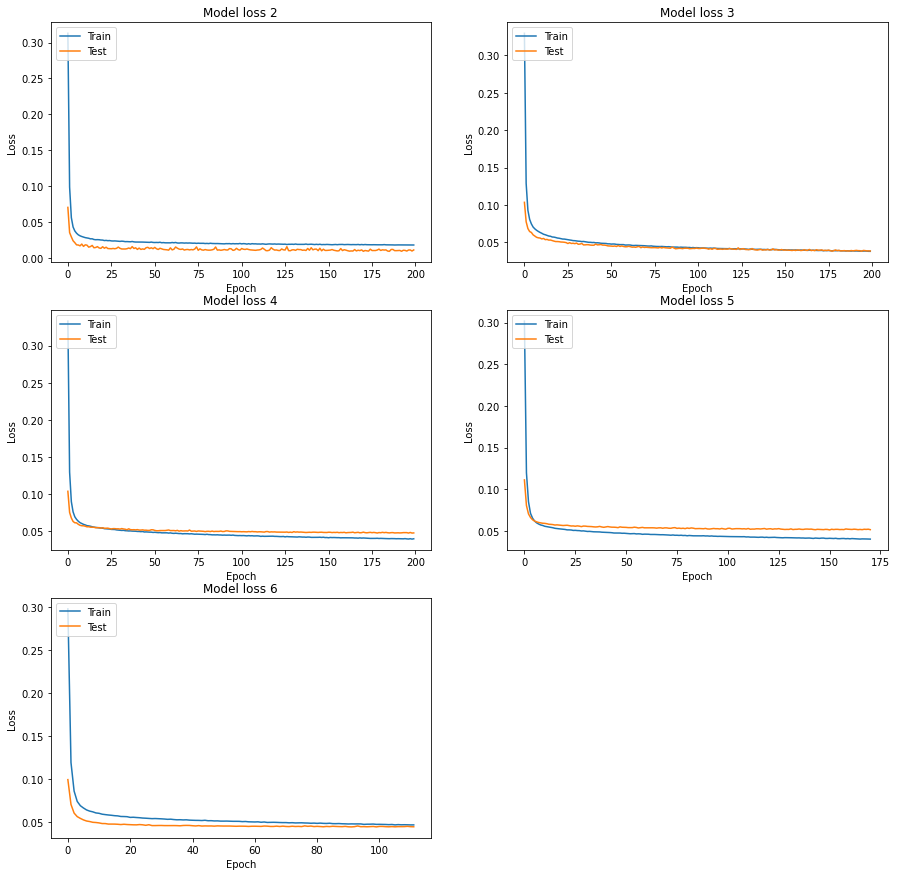

In [16]:
fig = plt.figure(figsize = (15, 15))
for i in range(5):
    fig.add_subplot(3, 2, i+1)
    plt.plot(history[i+2].history['loss'])
    plt.plot(history[i+2].history['val_loss'])
    plt.title('Model loss '+str(i+2))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

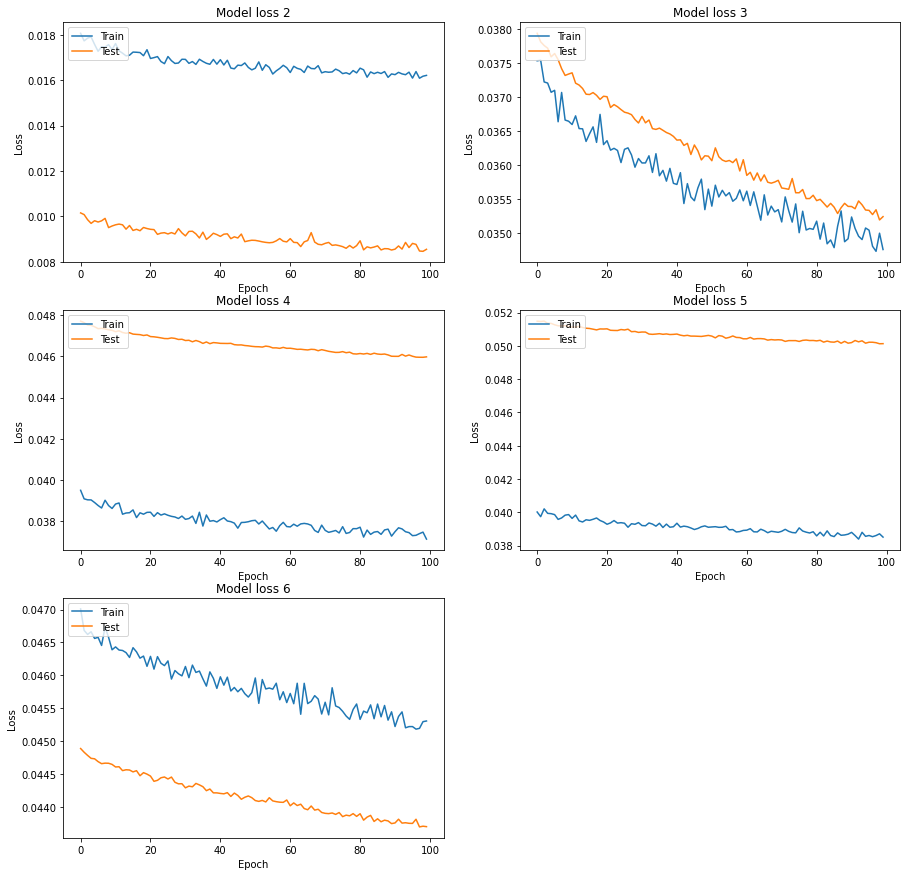

In [17]:
fig = plt.figure(figsize = (15, 15))
for i in range(5):
    fig.add_subplot(3, 2, i+1)
    plt.plot(history_ft[i+2].history['loss'])
    plt.plot(history_ft[i+2].history['val_loss'])
    plt.title('Model loss '+str(i+2))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')